In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import math

target_dates = [
    "2025-01-06 00:00", "2025-01-07 00:00", "2025-01-08 00:00",
    "2025-01-09 00:00", "2025-01-10 00:00", "2025-01-13 00:00",
    "2025-01-14 00:00", "2025-01-15 00:00", "2025-01-16 00:00",
    "2025-01-17 00:00"
]

bond_urls = [
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202225-bond-2025-ca135087p659?miRedirects=1",
       "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,122922756,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202325-bond-2025-ca135087q640?miRedirects=1",
      "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,126861078,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202326-bond-2026-ca135087r226?miRedirects=1",
     "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,130654501,1330,184&from=20240531&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202426-bond-2026-ca135087r978?miRedirects=1",
      "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,135402145,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202427-bond-2027-ca135087s547?miRedirects=1",
      "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,139591564,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202227-bond-2027-ca135087p733?miRedirects=1",
     "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,123653782,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202228-bond-2028-ca135087p576?miRedirects=1",
      "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,122651336,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202328-bond-2028-ca135087q491?miRedirects=1",
     "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,126528699,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202329-bond-2029-ca135087q988?miRedirects=1",
     "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,130328741,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202429-bond-2029-ca135087r895?miRedirects=1",
      "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,134387959,1330,184&from=20241130&to=20250131"),
    ("https://markets.businessinsider.com/bonds/canadacd-bonds_202430-bond-2030-ca135087s471?miRedirects=1",
     "https://markets.businessinsider.com/Ajax/Chart_GetChartData?instrumentType=Bond&tkData=1,138913105,16,184&from=20241130&to=20250131")
]

def scraper(url, url_data):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    isin_row = soup.find("td", string=lambda t: t and "isin" in t.lower())
    if isin_row:
        isin_value = isin_row.find_next_sibling("td").text.strip()
    else:
        isin_value = None
    coupon_rows = soup.find_all("td", string=lambda t: t and "coupon" in t.lower())
    if len(coupon_rows) > 1:
        second_coupon_row = coupon_rows[1]
        coupon_value_cell = second_coupon_row.find_next_sibling("td").text.strip()
        coupon_value = float(coupon_value_cell.replace('%', '')) / 100
    else:
        coupon_value = None
    issue_row = soup.find("td", string=lambda t: t and "issue date" in t.lower())
    if issue_row:
        issue_value = issue_row.find_next_sibling("td").text.strip()
    else:
        issue_value = None
    maturity_row = soup.find("td", string=lambda t: t and "maturity date" in t.lower())
    if maturity_row:
        maturity_value = maturity_row.find_next_sibling("td").text.strip()
    else:
        maturity_value = None
    print(f"Maturity date: {maturity_value}")
    response_data = requests.get(url_data)
    price_by_date = {}
    for entry in response_data.json():
        if entry["Date"] in target_dates:
            try:
                close_price = float(entry["Close"])
            except ValueError:
                close_price = entry["Close"]
            price_by_date[entry["Date"]] = close_price
            print(f"{entry['Close']} ({entry['Date']})")
    return maturity_value, price_by_date

def process_bonds(bond_list):
    results = []
    for bond in bond_list:
        result = scraper(bond[0], bond[1])
        results.append(result)
    return results

def write_to_excel(bond_data, target_dates, filename="bond_data.xlsx"):
    df = pd.DataFrame(index=target_dates)
    for maturity, price_dict in bond_data:
        column_data = [price_dict.get(date, None) for date in target_dates]
        df[maturity] = column_data
    df.index.name = "Date"
    df.to_excel(filename)
    print(f"Data written to {filename}")


In [2]:
coupon_rates = [3.75, 3.5, 4.5, 4, 3, 3.245, 3.5, 3.25, 4, 3.5, 2.75]


In [3]:
df = pd.read_excel("bond_data.xlsx", index_col=0)

organized_data = df.to_dict('index')
print(organized_data)


{'2025-01-06 00:00': {'2/1/2025': 100.03, '8/1/2025': 100.26, '2/1/2026': 101.58, '8/3/2026': 101.54, '2/1/2027': 100.11, '8/24/2027': 101.02, '3/1/2028': 101.82, '9/1/2028': 101.1, '3/1/2029': 104.07, '9/1/2029': 102.22, '3/1/2030': 98.81}, '2025-01-07 00:00': {'2/1/2025': 100.01, '8/1/2025': 100.25, '2/1/2026': 101.58, '8/3/2026': 101.57, '2/1/2027': 100.14, '8/24/2027': 101.04, '3/1/2028': 101.82, '9/1/2028': 101.14, '3/1/2029': 104.01, '9/1/2029': 102.14, '3/1/2030': 98.6}, '2025-01-08 00:00': {'2/1/2025': 100.03, '8/1/2025': 100.24, '2/1/2026': 101.56, '8/3/2026': 101.53, '2/1/2027': 100.08, '8/24/2027': 100.94, '3/1/2028': 101.7, '9/1/2028': 100.99, '3/1/2029': 103.9, '9/1/2029': 102.04, '3/1/2030': 98.53}, '2025-01-09 00:00': {'2/1/2025': 100.02, '8/1/2025': 100.25, '2/1/2026': 101.58, '8/3/2026': 101.55, '2/1/2027': 100.1, '8/24/2027': 101.02, '3/1/2028': 101.72, '9/1/2028': 100.94, '3/1/2029': 103.87, '9/1/2029': 101.98, '3/1/2030': 98.54}, '2025-01-10 00:00': {'2/1/2025': 100

In [4]:
def get_ith_day_prices(i):
    return df.iloc[i].tolist()

print(get_ith_day_prices(0))


[100.03, 100.26, 101.58, 101.54, 100.11, 101.02, 101.82, 101.1, 104.07, 102.22, 98.81]


In [5]:
def generate_ith_day_output(i, prices, coupons):
    output = []
    for j in range(1, len(prices)):
        tuple = (prices[j], coupons[j], j/2)
        output.append(tuple)
    return output

print(generate_ith_day_output(0, get_ith_day_prices(0), coupon_rates))


[(100.26, 3.5, 0.5), (101.58, 4.5, 1.0), (101.54, 4, 1.5), (100.11, 3, 2.0), (101.02, 3.245, 2.5), (101.82, 3.5, 3.0), (101.1, 3.25, 3.5), (104.07, 4, 4.0), (102.22, 3.5, 4.5), (98.81, 2.75, 5.0)]


In [6]:

def bootstrap_yield_curve(bonds, frequency=1):
    bonds = sorted(bonds, key=lambda x: x[2])
    max_period = int(bonds[-1][2] * frequency)
    spot_rates = np.zeros(max_period)
    for bond in bonds:
        price, annual_coupon, maturity_years = bond
        n_periods = int(maturity_years * frequency)
        coupon_payment = annual_coupon / frequency
        pv_coupons = 0
        for i in range(n_periods - 1):
            pv_coupons += coupon_payment / (1 + spot_rates[i])**(i + 1)
        spot_rate_n = ((coupon_payment + 100) / (price - pv_coupons))**(1 / n_periods) - 1
        spot_rates[n_periods - 1] = spot_rate_n
    return spot_rates


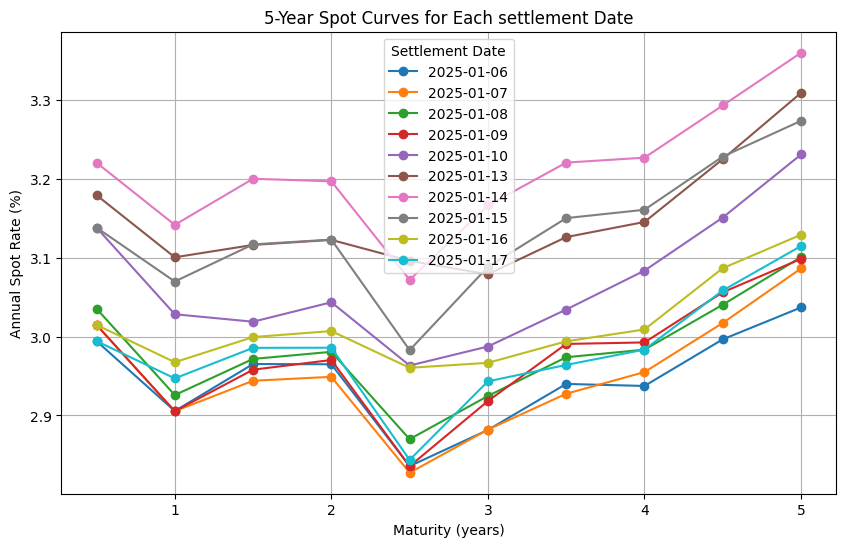

[[np.float64(0.02994358096039873), np.float64(0.02905561523138034), np.float64(0.02965208236954342), np.float64(0.029649425812214192), np.float64(0.028356366265544608), np.float64(0.028815786937813836), np.float64(0.029399614372580762), np.float64(0.029373921176203632), np.float64(0.029965560918589373), np.float64(0.03036975316452062)], [np.float64(0.03014906623715019), np.float64(0.029053325094131388), np.float64(0.029439846797594926), np.float64(0.029489753339503322), np.float64(0.02827303012712301), np.float64(0.028820163819574418), np.float64(0.02927501342102845), np.float64(0.029549923923244847), np.float64(0.03017319753815184), np.float64(0.030865096537888714)], [np.float64(0.030354613014957454), np.float64(0.029258205474966603), np.float64(0.029716946403421707), np.float64(0.029806926095333086), np.float64(0.028698431411851466), np.float64(0.029246674202197065), np.float64(0.029738171633740373), np.float64(0.02983484690196403), np.float64(0.030404558430181305), np.float64(0.0310

In [7]:


all_bonds = [generate_ith_day_output(i, get_ith_day_prices(i), coupon_rates) for i in range(10)]


rates_semi = []
for bond_data in all_bonds:
    semi_rates = bootstrap_yield_curve(bond_data, frequency=2)
    rates_semi.append(semi_rates)

rates_annual = []
for semi_rates in rates_semi:
    annual_rates = [(1 + r)**2 - 1 for r in semi_rates]
    rates_annual.append(annual_rates)

x_vals = np.arange(1, len(rates_annual[0]) + 1) / 2  

plt.figure(figsize=(10, 6))
for i, annual_rates in enumerate(rates_annual):
    plt.plot(x_vals, np.array(annual_rates) * 100, marker='o', label=target_dates[i].split()[0])

plt.xlabel("Maturity (years)")
plt.ylabel("Annual Spot Rate (%)")
plt.title("5-Year Spot Curves for Each settlement Date")
plt.legend(title="Settlement Date")
plt.grid(True)
plt.show()
print(rates_annual)


In [8]:
def compute_forward_rates(annual_rates, maturities):
    forward_rates = []
    for i in range(1, len(annual_rates)):
        T1 = maturities[i-1]
        T2 = maturities[i]
        s1 = annual_rates[i-1]
        s2 = annual_rates[i]
        f = ((1 + s2)**T2 / (1 + s1)**T1)**(1/(T2 - T1)) - 1
        forward_rates.append(f)
    return forward_rates


Bond with maturity 0.5 years: YTM = 2.97%
Bond with maturity 1.0 years: YTM = 2.89%
Bond with maturity 1.5 years: YTM = 2.94%
Bond with maturity 2.0 years: YTM = 2.94%
Bond with maturity 2.5 years: YTM = 2.82%
Bond with maturity 3.0 years: YTM = 2.86%
Bond with maturity 3.5 years: YTM = 2.92%
Bond with maturity 4.0 years: YTM = 2.91%
Bond with maturity 4.5 years: YTM = 2.97%
Bond with maturity 5.0 years: YTM = 3.01%
Settlement Date 2025-01-06: YTM values = [np.float64(2.972272179066339), np.float64(2.8857227241459893), np.float64(2.9429719125657785), np.float64(2.9429621917777053), np.float64(2.8195831750385727), np.float64(2.8625827032261633), np.float64(2.9171130823113716), np.float64(2.9146472849835887), np.float64(2.969325733546362), np.float64(3.008129319631471)]
Bond with maturity 0.5 years: YTM = 2.99%
Bond with maturity 1.0 years: YTM = 2.89%
Bond with maturity 1.5 years: YTM = 2.92%
Bond with maturity 2.0 years: YTM = 2.93%
Bond with maturity 2.5 years: YTM = 2.81%
Bond with m

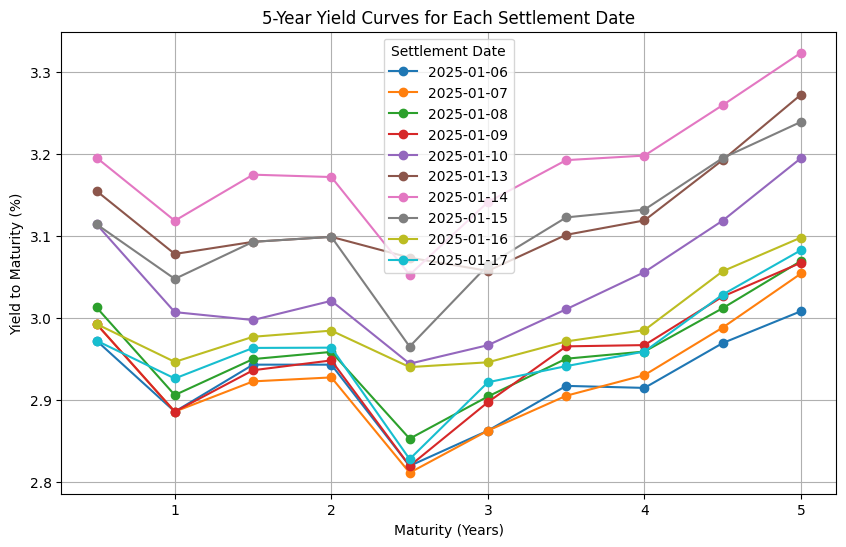

In [9]:
import matplotlib.pyplot as plt
from scipy.optimize import brentq

def bond_price(y, coupon, maturity, face=100):
    N = int(maturity * 2)
    price_calc = 0.0
    for i in range(1, N + 1):
        price_calc += (coupon / 2) / ((1 + y / 2) ** i)
    price_calc += face / ((1 + y / 2) ** N)
    return price_calc

def bond_ytm(price, coupon, maturity, face=100):
    y_candidates = np.linspace(0.0, 0.20, 2001)
    prices = [bond_price(y, coupon, maturity, face) for y in y_candidates]
    for i in range(len(prices) - 1):
        if (prices[i] - price) * (prices[i+1] - price) < 0:
            return y_candidates[i] + (y_candidates[i+1] - y_candidates[i]) * (price - prices[i]) / (prices[i+1] - prices[i])
    return None

def calculate_and_plot_yield_curves(data):
    plt.figure(figsize=(10, 6))
    for i, day_data in enumerate(data):
        maturities = []
        ytm_values = []
        for bond in day_data:
            price, coupon, maturity = bond
            ytm = bond_ytm(price, coupon, maturity)
            ytm_percent = ytm * 100 if ytm is not None else None
            maturities.append(maturity)
            ytm_values.append(ytm_percent)
            print(f"Bond with maturity {maturity} years: YTM = {round(ytm_percent, 2) if ytm_percent is not None else 'N/A'}%")
        print(f"Settlement Date {target_dates[i].split()[0]}: YTM values = {ytm_values}")
        plt.plot(maturities, ytm_values, marker='o', linestyle='-', label=target_dates[i].split()[0])
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Yield to Maturity (%)')
    plt.title('5-Year Yield Curves for Each Settlement Date')
    plt.legend(title='Settlement Date')
    plt.grid(True)
    plt.show()

calculate_and_plot_yield_curves(all_bonds)
all_ytm = []
for day_data in all_bonds:
    ytm_day = []
    for bond in day_data:
        price, coupon, maturity = bond
        ytm = bond_ytm(price, coupon, maturity)
        ytm_day.append(ytm * 100 if ytm is not None else None)
    all_ytm.append(ytm_day)



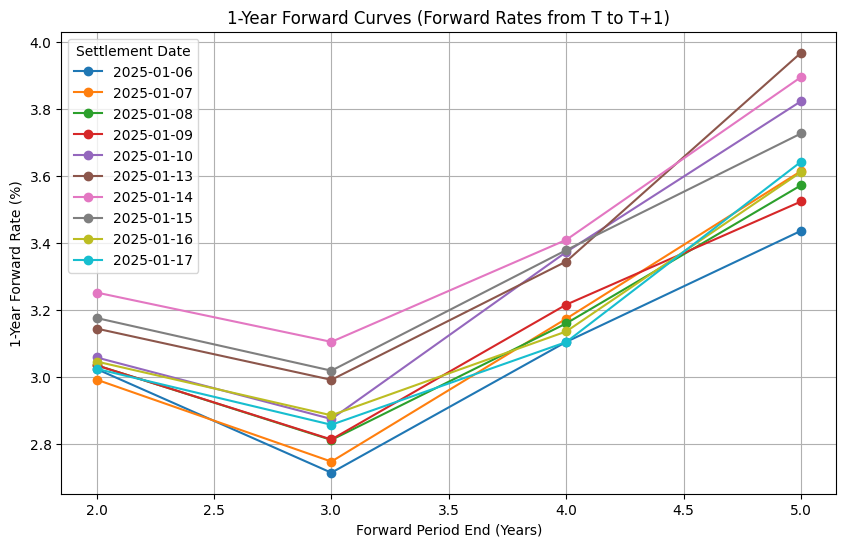

In [10]:

def compute_forward_rates_from_semi(semi_rates):
    indices = [1, 3, 5, 7, 9]
    annual_spot = [(1 + semi_rates[i])**2 - 1 for i in indices]
    discount_factors = [1 / ((1 + annual_spot[i])**(i + 1)) for i in range(len(annual_spot))]
    forward_rates = []
    for i in range(len(discount_factors) - 1):
        fwd = discount_factors[i] / discount_factors[i+1] - 1
        forward_rates.append(fwd)
    return forward_rates

forward_maturities = [2, 3, 4, 5]

all_forward_curves = []
for semi_rates in rates_semi:
    fwd_rates = compute_forward_rates_from_semi(semi_rates)
    all_forward_curves.append(fwd_rates)

plt.figure(figsize=(10, 6))
for i, fwd_curve in enumerate(all_forward_curves):
    plt.plot(forward_maturities, np.array(fwd_curve) * 100, marker='o', label=target_dates[i].split()[0])
plt.xlabel("Forward Period End (Years)")
plt.ylabel("1-Year Forward Rate (%)")
plt.title("1-Year Forward Curves (Forward Rates from T to T+1)")
plt.legend(title="Settlement Date")
plt.grid(True)
plt.show()


In [ ]:


forward_rates_array = np.array(rates_annual)
selected_forward_rates = forward_rates_array[:, 0:4]
log_returns_forward = np.log(selected_forward_rates[1:, :] / selected_forward_rates[:-1, :])
cov_forward = np.cov(log_returns_forward, rowvar=False)

yield_data_array = np.array(all_ytm)
log_returns_yield = np.log(yield_data_array[1:, :] / yield_data_array[:-1, :])
cov_yield = np.cov(log_returns_yield, rowvar=False)


In [ ]:


forward_rates_array = np.array(rates_annual)
selected_forward_rates = forward_rates_array[:, 0:4]
log_returns_forward = np.log(selected_forward_rates[1:, :] / selected_forward_rates[:-1, :])
cov_forward = np.cov(log_returns_forward, rowvar=False)
yield_data_array = np.array(all_ytm)
log_returns_yield = np.log(yield_data_array[1:, :] / yield_data_array[:-1, :])
cov_yield = np.cov(log_returns_yield, rowvar=False)
eigvals_forward, eigvecs_forward = np.linalg.eig(cov_forward)
eigvals_yield, eigvecs_yield = np.linalg.eig(cov_yield)

